Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['DATA', 'STORJ', 'RDN', 'KNC', 'BTC']
intervals = ['1m']
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install plotly python-binance --upgrade --no-cache-dir

Requirement already up-to-date: plotly in ./anaconda3/lib/python3.7/site-packages (4.8.1)
Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset=None, plot=False):
        if dataset is not None:
            self.dataset = dataset

        self.value = self.calculate(self.dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def __init__(self):
        self.indicators = None

    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        method='simple'):

        volume_average = self._calculate_moving_average_(dataset, 
                                                         window=average_1, 
                                                         method=method)

        relative_volume = dataset / average_1

        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, 
                                                                   window=average_2, 
                                                                   method=method)

        return smoothed_relative_volume[['volume']].pct_change()


class Cryptocurrency_triggers:
    def __init__(self):
        self.indicators = Cryptocurrency_indicators_base()

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = self.indicators.calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = self.indicators.calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.calculate_RSI(dataset, span=6)
        RSI_12 = self.indicators.calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0

    def calculate_relative_volume_level_trigger(self, dataset, threshold=1.5):
        relative_volume_level = self.indicators.calculate_relative_volume_level(dataset)
        return relative_volume_level['volume'] > threshold


class Cryptocurrency_indicators:
    def __init__(self):
        self.indicators = Cryptocurrency_triggers()
        self.setup()

    def setup(self):
        self._setup_(self.indicators)

    def update(self, dataset, plot=False):
        self._update_(self.indicators, dataset, plot=plot)

    def _setup_(self, cls):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._setup_(next_indicators)

        indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for indicator, calculator in zip(indicators, calculators):
            setattr(cls, 
                    indicator[10:], 
                    Cryptocurrency_indicator(name=indicator[10:], 
                                             calculate=calculator, 
                                             OHLC=False))

    def _update_(self, cls, dataset, plot=False):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._update_(next_indicators, dataset, plot=plot)

        indicators = [indicator for indicator in dir(cls)]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for calculator in calculators:
            if isinstance(calculator, Cryptocurrency_indicator):
                calculator.update(dataset, plot=plot)


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']
        self.base_asset_precision = pair_info['baseAssetPrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.base_asset_balance = "{:0.0{}f}".format(float(self.base_asset_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.quote_asset_balance = "{:0.0{}f}".format(float(self.quote_asset_balance), self.precision).rstrip('0').rstrip('.')

        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_last_price = "{:0.0{}f}".format(float(self.pair_last_price), self.precision).rstrip('0').rstrip('.')

        self.pair_buy_balance = float(self.quote_asset_balance) / float(self.pair_last_price)
        self.pair_buy_balance = "{:0.0{}f}".format(float(self.pair_buy_balance), self.base_asset_precision).rstrip('0').rstrip('.')

        self.pair_sell_balance = float(self.base_asset_balance) * float(self.pair_last_price)
        self.pair_sell_balance = "{:0.0{}f}".format(float(self.pair_sell_balance), self.precision).rstrip('0').rstrip('.')

        self.pair_combined_base_balance = float(self.pair_buy_balance) + float(self.base_asset_balance)
        self.pair_combined_base_balance = "{:0.0{}f}".format(float(self.pair_combined_base_balance), self.base_asset_precision).rstrip('0').rstrip('.')

        self.pair_combined_quote_balance = float(self.pair_sell_balance) + float(self.quote_asset_balance)
        self.pair_combined_quote_balance = "{:0.0{}f}".format(float(self.pair_combined_quote_balance), self.precision).rstrip('0').rstrip('.')

    def print_balance(self):
        print("\n")
        print('pair: ', self.pair)
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)
        print("\n")


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, download=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = self.get_n_periods_from_time(n=60)
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators()

    def get_n_periods_from_time(self, n=60):
        return str(int(self.interval[:-1]) * n) + self.interval[-1:]

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if float(self.info.pair_buy_balance) > float(self.info.base_asset_balance):
            self.position = 'sell'
        elif float(self.info.base_asset_balance) > float(self.info.pair_buy_balance):
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = float(self.info.pair_buy_balance)
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = float(self.info.base_asset_balance)
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        quantity = "{:0.0{}f}".format(float(quantity), self.info.precision).rstrip('0').rstrip('.')

        print('traded quantity:', quantity)
        self.pair.info.calculate_balance()
        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 raw_price=True, 
                 download=True):

        self.raw_price = raw_price
        self.download = download

        if self.raw_price:
            intervals = intervals + ['price']

        self.info = self.get_pair_info(client, pair)

        super().__init__(self)

        self.interval = self.get_datasets(client, intervals)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals):
        dataset = dict()

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                download=self.download)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 raw_price=False, 
                 initial_plot=False):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    raw_price, 
                                    traded_pair_symbols)

        self.assets = dict.fromkeys(traded_asset_symbols, 0)
        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)
        self.traded_pair_symbol = self.get_most_promising_pair()

        for pair in list(self.pairs.keys()):
            for interval in intervals:
                if initial_plot:
                    print("\n")
                    print('pair: ', pair)
                    print('interval: ', interval)

                self.pairs[pair].interval[interval].indicators.update(
                    self.pairs[pair].interval[interval].dataset, 
                    plot=initial_plot
                )

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  raw_price, 
                  traded_pair_symbols):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              raw_price=raw_price, 
                                              download=True)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



pair:  DATABTC
interval:  1m
ATR
time
2020-06-20 08:47:00    4.165481e-09
2020-06-20 08:48:00    4.165481e-09
2020-06-20 08:49:00    4.165481e-09
2020-06-20 08:50:00    4.165481e-09
2020-06-20 08:51:00    4.165481e-09
                           ...     
2020-06-20 13:42:00    1.425133e-08
2020-06-20 13:43:00    1.466195e-08
2020-06-20 13:44:00    1.575752e-08
2020-06-20 13:45:00    1.534627e-08
2020-06-20 13:46:00    1.425011e-08
Length: 300, dtype: float64


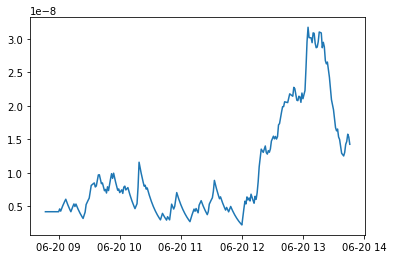



KDJ
                             K          D           J
time                                                 
2020-06-20 08:47:00  33.333333  44.444444   11.111111
2020-06-20 08:48:00  22.222222  37.037037   -7.407407
2020-06-20 08:49:00  14.814815  29.629630  -14.814815
2020-06-20 08:50:00   9.876543  23.045267  -16.460905
2020-06-20 08:51:00  39.917695  28.669410   62.414266
...                        ...        ...         ...
2020-06-20 13:42:00  93.187165  85.092445  109.376605
2020-06-20 13:43:00  95.458110  88.547667  109.278997
2020-06-20 13:44:00  71.972073  83.022469   49.871282
2020-06-20 13:45:00  56.314716  74.119885   20.704378
2020-06-20 13:46:00  45.876477  64.705415    8.218600

[300 rows x 3 columns]


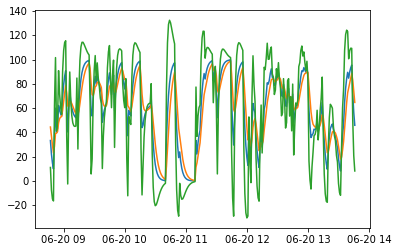



MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-20 08:47:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-06-20 08:48:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-06-20 08:49:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-06-20 08:50:00 -3.610462e-10 -1.223056e-10 -2.387406e-10
2020-06-20 08:51:00 -1.517093e-10 -1.310526e-10 -2.065678e-11
...                           ...           ...           ...
2020-06-20 13:42:00  8.492647e-10 -4.343672e-09  5.192937e-09
2020-06-20 13:43:00  3.313648e-09 -2.812208e-09  6.125856e-09
2020-06-20 13:44:00  2.813509e-09 -1.687065e-09  4.500573e-09
2020-06-20 13:45:00  2.389598e-09 -8.717320e-10  3.261330e-09
2020-06-20 13:46:00  2.030243e-09 -2.913370e-10  2.321580e-09

[300 rows x 3 columns]


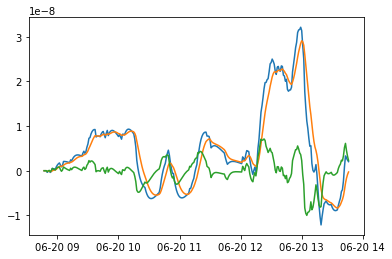



RSI
time
2020-06-20 08:47:00          NaN
2020-06-20 08:48:00          NaN
2020-06-20 08:49:00          NaN
2020-06-20 08:50:00     0.000000
2020-06-20 08:51:00    53.613054
                         ...    
2020-06-20 13:42:00    79.205582
2020-06-20 13:43:00    79.205582
2020-06-20 13:44:00    48.986669
2020-06-20 13:45:00    48.986669
2020-06-20 13:46:00    48.986669
Name: close, Length: 300, dtype: float64


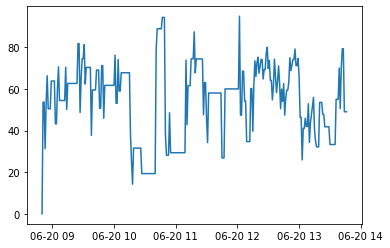



average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-20 09:13:00  0.329622  0.513945  0.148588
2020-06-20 09:14:00  0.386213  0.682849  0.118410
2020-06-20 09:15:00  0.362012  0.550534  0.349696
2020-06-20 09:16:00  0.341708  0.512737  0.325687
2020-06-20 09:17:00  0.324590  0.413403  0.262591
...                       ...       ...       ...
2020-06-20 13:41:00  0.201357  0.451065  0.194020
2020-06-20 13:42:00  0.227638  0.357693  0.153857
2020-06-20 13:43:00  0.216442  0.301319  0.402423
2020-06-20 13:44:00  0.206739  0.242986  0.324518
2020-06-20 13:45:00  0.198329  0.216232  0.288786

[273 rows x 3 columns]


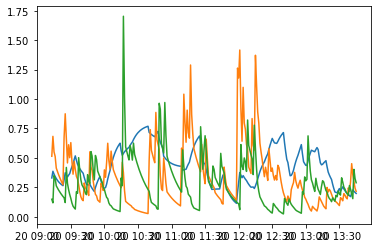



bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-20 09:06:00  0.000006  0.000006  0.000000e+00
2020-06-20 09:07:00  0.000006  0.000006  2.236068e-10
2020-06-20 09:08:00  0.000006  0.000006  4.893605e-10
2020-06-20 09:09:00  0.000006  0.000006  8.013147e-10
2020-06-20 09:10:00  0.000006  0.000006  1.316894e-09
...                       ...       ...           ...
2020-06-20 13:42:00  0.000006  0.000006  1.355098e-08
2020-06-20 13:43:00  0.000006  0.000006  1.224089e-08
2020-06-20 13:44:00  0.000006  0.000006  1.081556e-08
2020-06-20 13:45:00  0.000006  0.000006  9.383496e-09
2020-06-20 13:46:00  0.000006  0.000006  8.124038e-09

[281 rows x 3 columns]


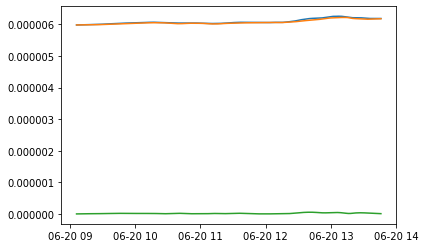



commodity_channel_index
time
2020-06-20 08:47:00         NaN
2020-06-20 08:48:00         NaN
2020-06-20 08:49:00         NaN
2020-06-20 08:50:00         NaN
2020-06-20 08:51:00         NaN
                         ...   
2020-06-20 13:42:00    2.689839
2020-06-20 13:43:00    2.658588
2020-06-20 13:44:00    0.741866
2020-06-20 13:45:00    0.479730
2020-06-20 13:46:00    0.442813
Name: CCI, Length: 300, dtype: float64


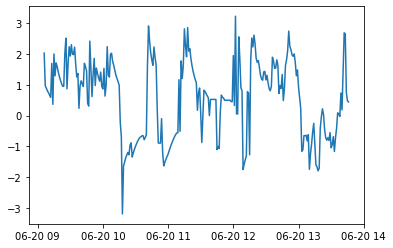



exponential_moving_average
                         open      high       low     close        volume
time                                                                     
2020-06-20 08:47:00  0.000006  0.000006  0.000006  0.000006   6023.000000
2020-06-20 08:48:00  0.000006  0.000006  0.000006  0.000006   1505.750000
2020-06-20 08:49:00  0.000006  0.000006  0.000006  0.000006    463.307692
2020-06-20 08:50:00  0.000006  0.000006  0.000006  0.000006    171.500000
2020-06-20 08:51:00  0.000006  0.000006  0.000006  0.000006    949.702479
...                       ...       ...       ...       ...           ...
2020-06-20 13:42:00  0.000006  0.000006  0.000006  0.000006  11341.378801
2020-06-20 13:43:00  0.000006  0.000006  0.000006  0.000006   3959.792934
2020-06-20 13:44:00  0.000006  0.000006  0.000006  0.000006   4824.597645
2020-06-20 13:45:00  0.000006  0.000006  0.000006  0.000006   1608.199215
2020-06-20 13:46:00  0.000006  0.000006  0.000006  0.000006    536.066405

[300 row

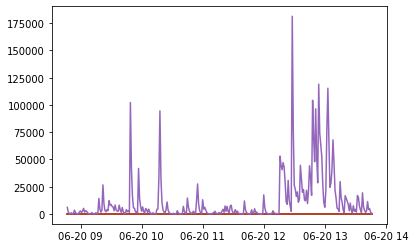



heikin_ashi
                         open      high       low     close
2020-06-20 08:47:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 08:48:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 08:49:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 08:50:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 08:51:00  0.000006  0.000006  0.000006  0.000006
...                       ...       ...       ...       ...
2020-06-20 13:42:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 13:43:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 13:44:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 13:45:00  0.000006  0.000006  0.000006  0.000006
2020-06-20 13:46:00  0.000006  0.000006  0.000006  0.000006

[300 rows x 4 columns]


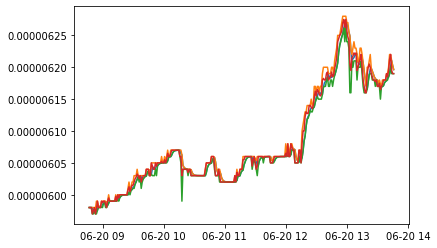



relative_volume_level
                       volume
time                         
2020-06-20 08:47:00       NaN
2020-06-20 08:48:00  0.000000
2020-06-20 08:49:00  0.000000
2020-06-20 08:50:00  0.000000
2020-06-20 08:51:00  0.000000
...                       ...
2020-06-20 13:42:00  0.052482
2020-06-20 13:43:00  0.002719
2020-06-20 13:44:00  0.003185
2020-06-20 13:45:00 -0.004802
2020-06-20 13:46:00 -0.246714

[300 rows x 1 columns]


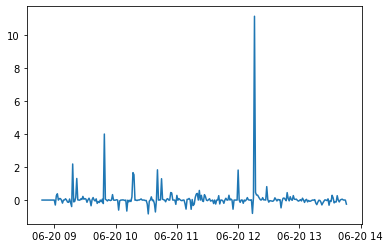



simple_moving_average
                         open      high       low     close  volume
time                                                               
2020-06-20 08:47:00  0.000006  0.000006  0.000006  0.000006  3011.5
2020-06-20 08:48:00  0.000006  0.000006  0.000006  0.000006  3011.5
2020-06-20 08:49:00  0.000006  0.000006  0.000006  0.000006     0.0
2020-06-20 08:50:00  0.000006  0.000006  0.000006  0.000006    15.5
2020-06-20 08:51:00  0.000006  0.000006  0.000006  0.000006   682.5
...                       ...       ...       ...       ...     ...
2020-06-20 13:42:00  0.000006  0.000006  0.000006  0.000006  9564.0
2020-06-20 13:43:00  0.000006  0.000006  0.000006  0.000006  7950.5
2020-06-20 13:44:00  0.000006  0.000006  0.000006  0.000006  2763.0
2020-06-20 13:45:00  0.000006  0.000006  0.000006  0.000006  2628.5
2020-06-20 13:46:00  0.000006  0.000006  0.000006  0.000006     0.0

[300 rows x 5 columns]


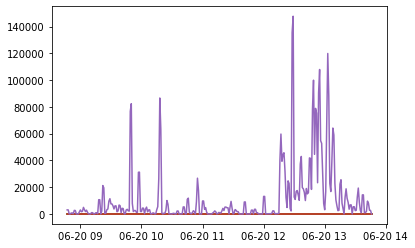



MACD_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
2020-06-20 13:46:00    1.0
Name: histogram, Length: 300, dtype: float64


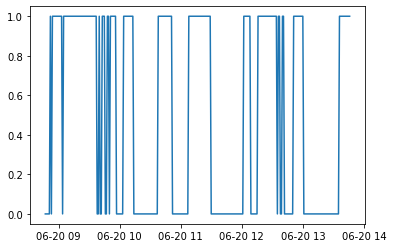



momentum_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


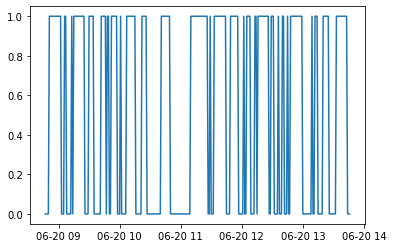



overtraded_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Name: close, Length: 300, dtype: float64


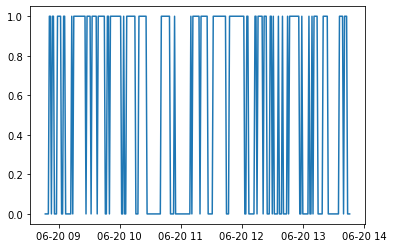



real_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


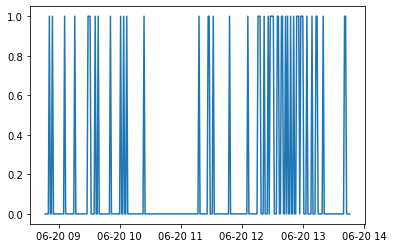



relative_volume_level_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Name: volume, Length: 300, dtype: float64


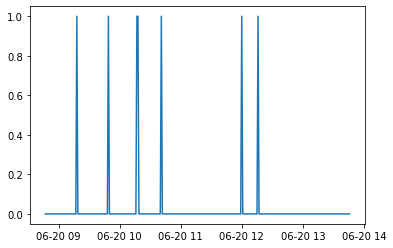



trend_strength_negative_trigger
time
2020-06-20 09:13:00    0.0
2020-06-20 09:14:00    0.0
2020-06-20 09:15:00    0.0
2020-06-20 09:16:00    0.0
2020-06-20 09:17:00    0.0
                      ... 
2020-06-20 13:41:00    0.0
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
Length: 273, dtype: float64


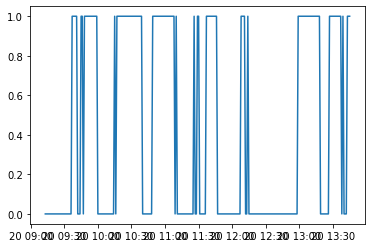



trend_strength_positive_trigger
time
2020-06-20 09:13:00    1.0
2020-06-20 09:14:00    1.0
2020-06-20 09:15:00    1.0
2020-06-20 09:16:00    1.0
2020-06-20 09:17:00    1.0
                      ... 
2020-06-20 13:41:00    1.0
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
Length: 273, dtype: float64


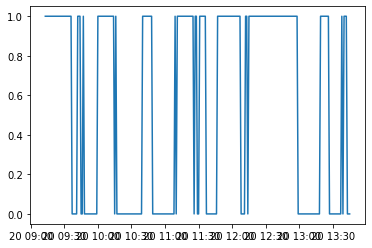



trend_strength_trigger
time
2020-06-20 09:13:00    1.0
2020-06-20 09:14:00    1.0
2020-06-20 09:15:00    1.0
2020-06-20 09:16:00    1.0
2020-06-20 09:17:00    1.0
                      ... 
2020-06-20 13:41:00    0.0
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
Name: ADX, Length: 273, dtype: float64


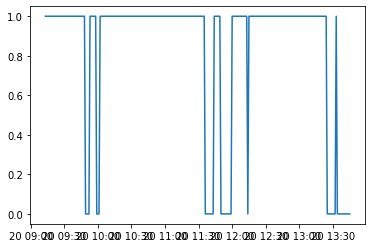



trend_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


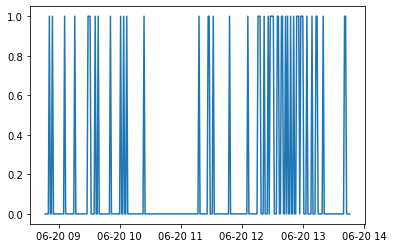



volatility_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
2020-06-20 13:46:00    1.0
Length: 300, dtype: float64


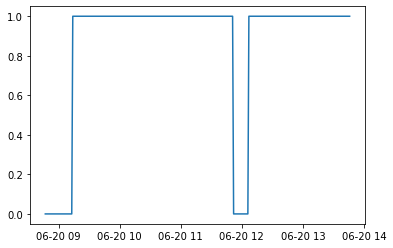





pair:  STORJBTC
interval:  1m
ATR
time
2020-06-20 08:47:00    1.854061e-08
2020-06-20 08:48:00    1.854061e-08
2020-06-20 08:49:00    1.854061e-08
2020-06-20 08:50:00    1.854061e-08
2020-06-20 08:51:00    1.854061e-08
                           ...     
2020-06-20 13:42:00    4.837938e-08
2020-06-20 13:43:00    4.849514e-08
2020-06-20 13:44:00    5.503120e-08
2020-06-20 13:45:00    5.752897e-08
2020-06-20 13:46:00    5.341976e-08
Length: 300, dtype: float64


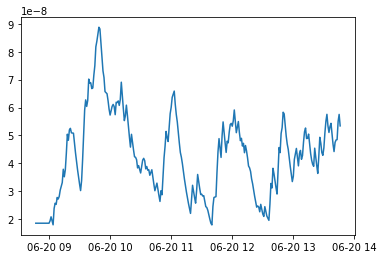



KDJ
                             K          D           J
time                                                 
2020-06-20 08:47:00  33.333333  44.444444   11.111111
2020-06-20 08:48:00  22.222222  37.037037   -7.407407
2020-06-20 08:49:00  14.814815  29.629630  -14.814815
2020-06-20 08:50:00   9.876543  23.045267  -16.460905
2020-06-20 08:51:00   6.584362  17.558299  -15.363512
...                        ...        ...         ...
2020-06-20 13:42:00  29.340102  33.370453   21.279400
2020-06-20 13:43:00  22.590371  29.777092    8.216929
2020-06-20 13:44:00  48.393581  35.982588   73.215565
2020-06-20 13:45:00  65.595720  45.853632  105.079897
2020-06-20 13:46:00  77.063814  56.257026  118.677389

[300 rows x 3 columns]


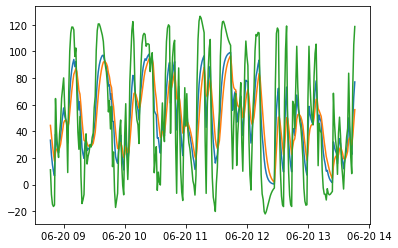



MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-20 08:47:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-06-20 08:48:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-06-20 08:49:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-06-20 08:50:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-06-20 08:51:00 -2.785461e-09 -8.286117e-10 -1.956849e-09
...                           ...           ...           ...
2020-06-20 13:42:00 -5.806854e-08 -5.220733e-08 -5.861204e-09
2020-06-20 13:43:00 -6.015811e-08 -5.379749e-08 -6.360621e-09
2020-06-20 13:44:00 -4.994159e-08 -5.302631e-08  3.084722e-09
2020-06-20 13:45:00 -4.136805e-08 -5.069466e-08  9.326605e-09
2020-06-20 13:46:00 -3.417947e-08 -4.739162e-08  1.321215e-08

[300 rows x 3 columns]


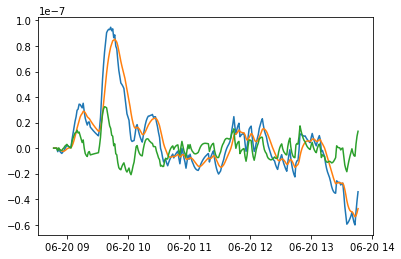



RSI
time
2020-06-20 08:47:00          NaN
2020-06-20 08:48:00          NaN
2020-06-20 08:49:00          NaN
2020-06-20 08:50:00          NaN
2020-06-20 08:51:00     0.000000
                         ...    
2020-06-20 13:42:00    25.784607
2020-06-20 13:43:00    25.784607
2020-06-20 13:44:00    60.498084
2020-06-20 13:45:00    60.498084
2020-06-20 13:46:00    60.498084
Name: close, Length: 300, dtype: float64


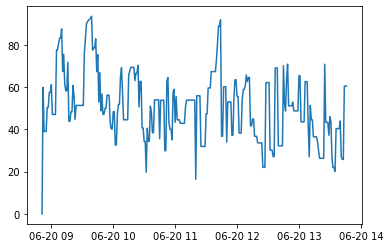



average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-20 09:13:00  0.672979  0.613195  0.077182
2020-06-20 09:14:00  0.688595  0.463072  0.058286
2020-06-20 09:15:00  0.713468  0.700733  0.054267
2020-06-20 09:16:00  0.672644  0.565981  0.223298
2020-06-20 09:17:00  0.638229  0.423481  0.167077
...                       ...       ...       ...
2020-06-20 13:41:00  0.230232  0.150840  0.387106
2020-06-20 13:42:00  0.258094  0.128313  0.329293
2020-06-20 13:43:00  0.259750  0.495857  0.284706
2020-06-20 13:44:00  0.261184  0.378702  0.217440
2020-06-20 13:45:00  0.262428  0.313959  0.180266

[273 rows x 3 columns]


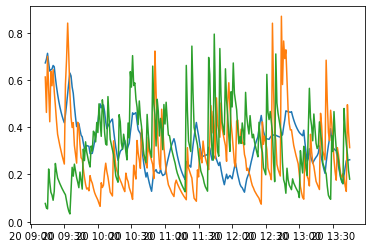



bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-20 09:06:00  0.000020  0.000020  0.000000e+00
2020-06-20 09:07:00  0.000020  0.000020  2.236068e-09
2020-06-20 09:08:00  0.000020  0.000020  5.295480e-09
2020-06-20 09:09:00  0.000020  0.000020  8.950742e-09
2020-06-20 09:10:00  0.000020  0.000020  1.370209e-08
...                       ...       ...           ...
2020-06-20 13:42:00  0.000021  0.000021  9.627051e-08
2020-06-20 13:43:00  0.000021  0.000020  9.838453e-08
2020-06-20 13:44:00  0.000021  0.000020  9.935190e-08
2020-06-20 13:45:00  0.000021  0.000020  9.918770e-08
2020-06-20 13:46:00  0.000021  0.000020  9.834574e-08

[281 rows x 3 columns]


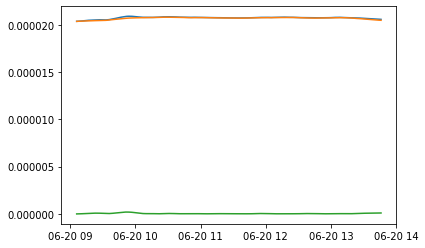



commodity_channel_index
time
2020-06-20 08:47:00         NaN
2020-06-20 08:48:00         NaN
2020-06-20 08:49:00         NaN
2020-06-20 08:50:00         NaN
2020-06-20 08:51:00         NaN
                         ...   
2020-06-20 13:42:00   -1.372980
2020-06-20 13:43:00   -1.407738
2020-06-20 13:44:00   -0.022843
2020-06-20 13:45:00    0.489509
2020-06-20 13:46:00    0.579132
Name: CCI, Length: 300, dtype: float64


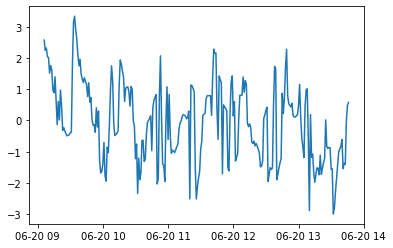



exponential_moving_average
                         open      high       low     close       volume
time                                                                    
2020-06-20 08:47:00  0.000020  0.000020  0.000020  0.000020     0.000000
2020-06-20 08:48:00  0.000020  0.000020  0.000020  0.000020     0.000000
2020-06-20 08:49:00  0.000020  0.000020  0.000020  0.000020     0.000000
2020-06-20 08:50:00  0.000020  0.000020  0.000020  0.000020    27.675000
2020-06-20 08:51:00  0.000020  0.000020  0.000020  0.000020    34.586777
...                       ...       ...       ...       ...          ...
2020-06-20 13:42:00  0.000020  0.000020  0.000020  0.000020   197.574315
2020-06-20 13:43:00  0.000020  0.000020  0.000020  0.000020    72.524772
2020-06-20 13:44:00  0.000020  0.000021  0.000020  0.000021  2198.174924
2020-06-20 13:45:00  0.000021  0.000021  0.000021  0.000021   732.724975
2020-06-20 13:46:00  0.000021  0.000021  0.000021  0.000021   244.241658

[300 rows x 5 columns

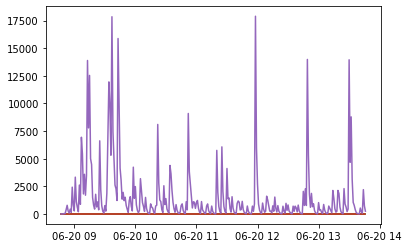



heikin_ashi
                         open      high       low     close
2020-06-20 08:47:00  0.000020  0.000020  0.000020  0.000020
2020-06-20 08:48:00  0.000020  0.000020  0.000020  0.000020
2020-06-20 08:49:00  0.000020  0.000020  0.000020  0.000020
2020-06-20 08:50:00  0.000020  0.000020  0.000020  0.000020
2020-06-20 08:51:00  0.000020  0.000020  0.000020  0.000020
...                       ...       ...       ...       ...
2020-06-20 13:42:00  0.000020  0.000020  0.000020  0.000020
2020-06-20 13:43:00  0.000020  0.000020  0.000020  0.000020
2020-06-20 13:44:00  0.000020  0.000021  0.000020  0.000021
2020-06-20 13:45:00  0.000020  0.000021  0.000020  0.000021
2020-06-20 13:46:00  0.000021  0.000021  0.000021  0.000021

[300 rows x 4 columns]


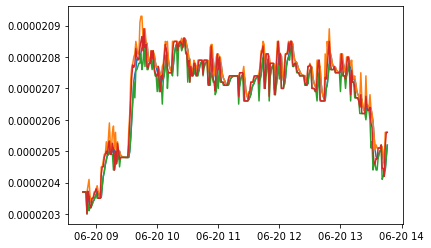



relative_volume_level
                       volume
time                         
2020-06-20 08:47:00       NaN
2020-06-20 08:48:00  0.000000
2020-06-20 08:49:00  0.000000
2020-06-20 08:50:00  0.000000
2020-06-20 08:51:00  0.000000
...                       ...
2020-06-20 13:42:00  0.000909
2020-06-20 13:43:00 -0.016146
2020-06-20 13:44:00 -0.519746
2020-06-20 13:45:00 -0.002543
2020-06-20 13:46:00 -0.674086

[300 rows x 1 columns]


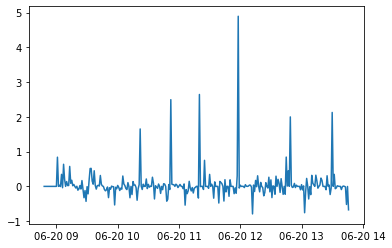



simple_moving_average
                         open      high       low     close  volume
time                                                               
2020-06-20 08:47:00  0.000020  0.000020  0.000020  0.000020     0.0
2020-06-20 08:48:00  0.000020  0.000020  0.000020  0.000020     0.0
2020-06-20 08:49:00  0.000020  0.000020  0.000020  0.000020     0.0
2020-06-20 08:50:00  0.000020  0.000020  0.000020  0.000020    20.5
2020-06-20 08:51:00  0.000020  0.000020  0.000020  0.000020    39.5
...                       ...       ...       ...       ...     ...
2020-06-20 13:42:00  0.000020  0.000020  0.000020  0.000020   412.0
2020-06-20 13:43:00  0.000020  0.000020  0.000020  0.000020    20.5
2020-06-20 13:44:00  0.000020  0.000020  0.000020  0.000020  1635.5
2020-06-20 13:45:00  0.000021  0.000021  0.000021  0.000021  1630.5
2020-06-20 13:46:00  0.000021  0.000021  0.000021  0.000021     0.0

[300 rows x 5 columns]


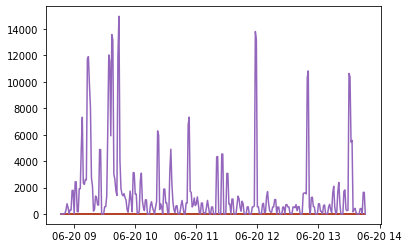



MACD_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
2020-06-20 13:46:00    1.0
Name: histogram, Length: 300, dtype: float64


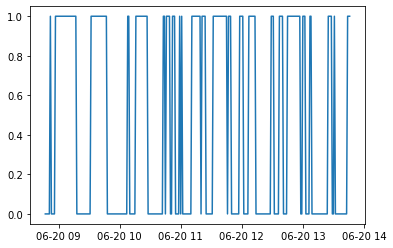



momentum_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
2020-06-20 13:46:00    1.0
Length: 300, dtype: float64


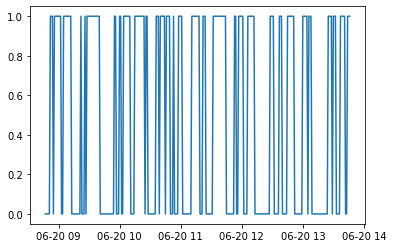



overtraded_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
2020-06-20 13:46:00    1.0
Name: close, Length: 300, dtype: float64


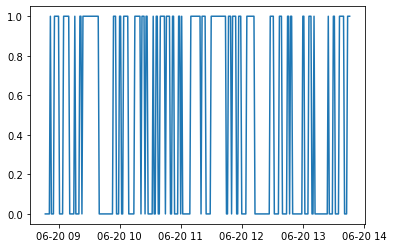



real_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


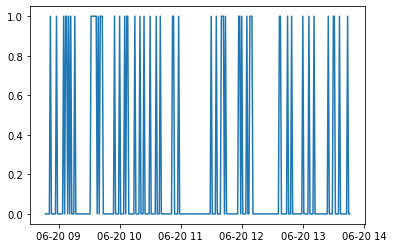



relative_volume_level_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Name: volume, Length: 300, dtype: float64


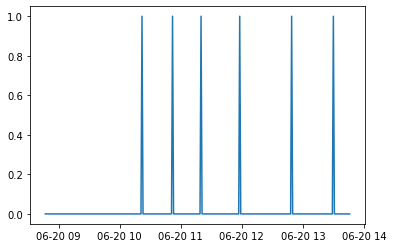



trend_strength_negative_trigger
time
2020-06-20 09:13:00    0.0
2020-06-20 09:14:00    0.0
2020-06-20 09:15:00    0.0
2020-06-20 09:16:00    0.0
2020-06-20 09:17:00    0.0
                      ... 
2020-06-20 13:41:00    1.0
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
Length: 273, dtype: float64


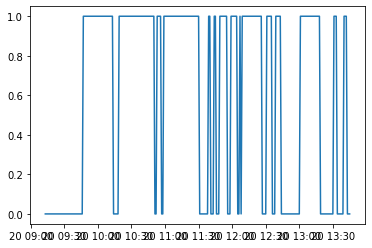



trend_strength_positive_trigger
time
2020-06-20 09:13:00    1.0
2020-06-20 09:14:00    1.0
2020-06-20 09:15:00    1.0
2020-06-20 09:16:00    1.0
2020-06-20 09:17:00    1.0
                      ... 
2020-06-20 13:41:00    0.0
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
Length: 273, dtype: float64


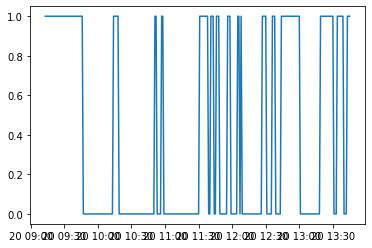



trend_strength_trigger
time
2020-06-20 09:13:00    1.0
2020-06-20 09:14:00    1.0
2020-06-20 09:15:00    1.0
2020-06-20 09:16:00    1.0
2020-06-20 09:17:00    1.0
                      ... 
2020-06-20 13:41:00    0.0
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
Name: ADX, Length: 273, dtype: float64


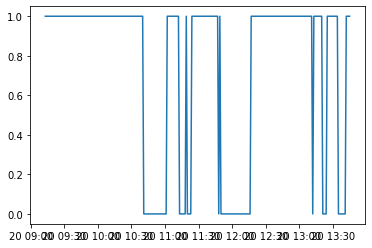



trend_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


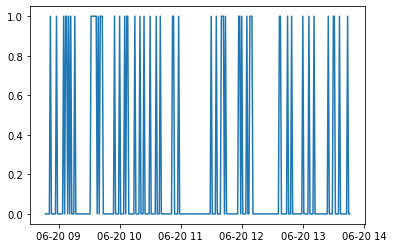



volatility_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
2020-06-20 13:46:00    1.0
Length: 300, dtype: float64


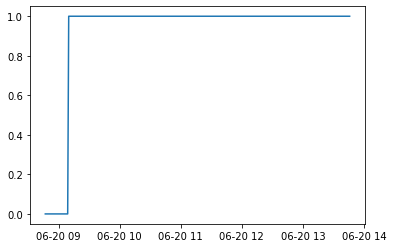





pair:  RDNBTC
interval:  1m
ATR
time
2020-06-20 08:47:00    1.488806e-08
2020-06-20 08:48:00    1.488806e-08
2020-06-20 08:49:00    1.488806e-08
2020-06-20 08:50:00    1.488806e-08
2020-06-20 08:51:00    1.488806e-08
                           ...     
2020-06-20 13:42:00    2.519680e-08
2020-06-20 13:43:00    2.839702e-08
2020-06-20 13:44:00    2.708295e-08
2020-06-20 13:45:00    2.657703e-08
2020-06-20 13:46:00    2.539295e-08
Length: 300, dtype: float64


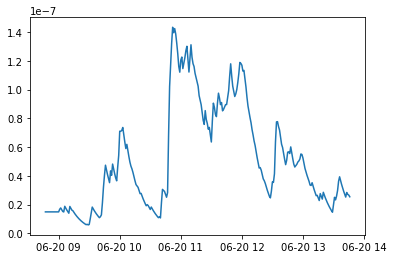



KDJ
                             K          D          J
time                                                
2020-06-20 08:47:00  33.333333  44.444444  11.111111
2020-06-20 08:48:00  55.555556  48.148148  70.370370
2020-06-20 08:49:00  41.203704  45.833333  31.944444
2020-06-20 08:50:00  54.552469  48.739712  66.177984
2020-06-20 08:51:00  63.451646  53.643690  83.067558
...                        ...        ...        ...
2020-06-20 13:42:00  43.086494  43.240688  42.778106
2020-06-20 13:43:00  28.724329  38.401902   9.369185
2020-06-20 13:44:00  19.149553  31.984452  -6.520246
2020-06-20 13:45:00  12.766369  25.578424 -12.857743
2020-06-20 13:46:00   8.510912  19.889254 -14.245770

[300 rows x 3 columns]


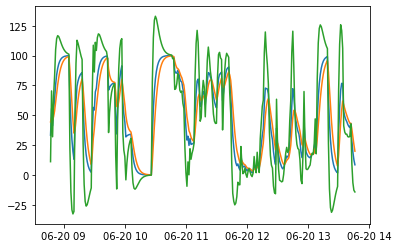



MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-20 08:47:00  3.365385e-09  3.365385e-09  0.000000e+00
2020-06-20 08:48:00  3.365385e-09  3.365385e-09  0.000000e+00
2020-06-20 08:49:00  2.568758e-10  2.091406e-09 -1.834530e-09
2020-06-20 08:50:00  2.808278e-09  2.334248e-09  4.740293e-10
2020-06-20 08:51:00  4.135550e-09  2.870095e-09  1.265455e-09
...                           ...           ...           ...
2020-06-20 13:42:00  3.473345e-09  9.932110e-10  2.480134e-09
2020-06-20 13:43:00 -2.163942e-09  3.617804e-10 -2.525722e-09
2020-06-20 13:44:00 -6.555959e-09 -1.021768e-09 -5.534192e-09
2020-06-20 13:45:00 -1.151773e-08 -3.120960e-09 -8.396769e-09
2020-06-20 13:46:00 -1.527390e-08 -5.551547e-09 -9.722351e-09

[300 rows x 3 columns]


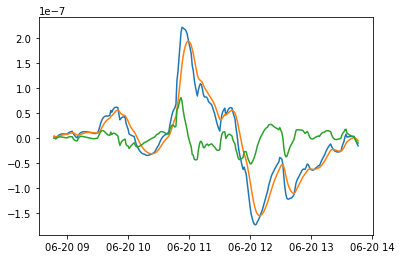



RSI
time
2020-06-20 08:47:00    100.000000
2020-06-20 08:48:00    100.000000
2020-06-20 08:49:00     50.150814
2020-06-20 08:50:00     66.527174
2020-06-20 08:51:00     66.527174
                          ...    
2020-06-20 13:42:00     52.048493
2020-06-20 13:43:00     30.491235
2020-06-20 13:44:00     30.491235
2020-06-20 13:45:00     26.331110
2020-06-20 13:46:00     26.331110
Name: close, Length: 300, dtype: float64


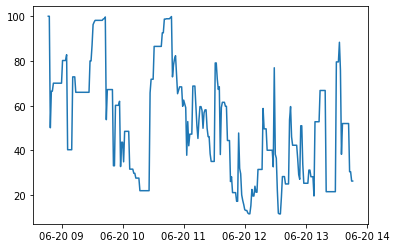



average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-20 09:13:00  0.429960  0.558079  0.284847
2020-06-20 09:14:00  0.413984  0.495707  0.253012
2020-06-20 09:15:00  0.400656  0.461520  0.235563
2020-06-20 09:16:00  0.389473  0.429834  0.219390
2020-06-20 09:17:00  0.380045  0.400439  0.204387
...                       ...       ...       ...
2020-06-20 13:41:00  0.279712  0.192846  0.246877
2020-06-20 13:42:00  0.314281  0.179989  0.600836
2020-06-20 13:43:00  0.344240  0.138411  0.462041
2020-06-20 13:44:00  0.379602  0.125777  0.518328
2020-06-20 13:45:00  0.410248  0.111082  0.457769

[273 rows x 3 columns]


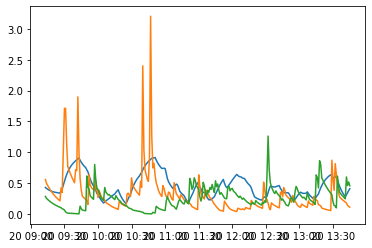



bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-20 09:06:00  0.000025  0.000025  0.000000e+00
2020-06-20 09:07:00  0.000025  0.000025  3.130495e-09
2020-06-20 09:08:00  0.000025  0.000025  4.158378e-09
2020-06-20 09:09:00  0.000025  0.000025  6.707419e-09
2020-06-20 09:10:00  0.000025  0.000025  8.466031e-09
...                       ...       ...           ...
2020-06-20 13:42:00  0.000025  0.000025  6.858533e-09
2020-06-20 13:43:00  0.000025  0.000025  7.506313e-09
2020-06-20 13:44:00  0.000025  0.000025  8.194189e-09
2020-06-20 13:45:00  0.000025  0.000025  8.635301e-09
2020-06-20 13:46:00  0.000025  0.000025  8.825203e-09

[281 rows x 3 columns]


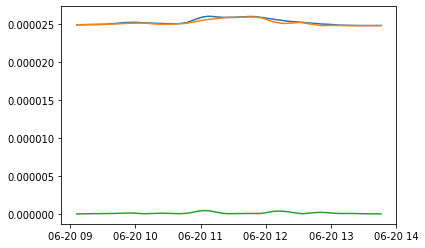



commodity_channel_index
time
2020-06-20 08:47:00         NaN
2020-06-20 08:48:00         NaN
2020-06-20 08:49:00         NaN
2020-06-20 08:50:00         NaN
2020-06-20 08:51:00         NaN
                         ...   
2020-06-20 13:42:00    0.411938
2020-06-20 13:43:00   -1.094630
2020-06-20 13:44:00   -1.169862
2020-06-20 13:45:00   -1.488005
2020-06-20 13:46:00   -1.493994
Name: CCI, Length: 300, dtype: float64


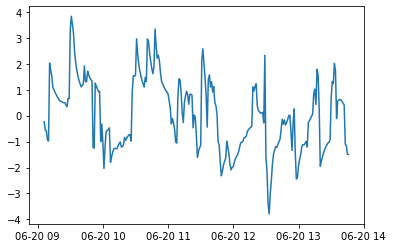



exponential_moving_average
                         open      high       low     close       volume
time                                                                    
2020-06-20 08:47:00  0.000025  0.000025  0.000025  0.000025     0.000000
2020-06-20 08:48:00  0.000025  0.000025  0.000025  0.000025   504.000000
2020-06-20 08:49:00  0.000025  0.000025  0.000025  0.000025  5553.692308
2020-06-20 08:50:00  0.000025  0.000025  0.000025  0.000025  3224.475000
2020-06-20 08:51:00  0.000025  0.000025  0.000025  0.000025  1065.942149
...                       ...       ...       ...       ...          ...
2020-06-20 13:42:00  0.000025  0.000025  0.000025  0.000025     0.225426
2020-06-20 13:43:00  0.000025  0.000025  0.000025  0.000025   628.741809
2020-06-20 13:44:00  0.000025  0.000025  0.000025  0.000025  3066.913936
2020-06-20 13:45:00  0.000025  0.000025  0.000025  0.000025  1416.304645
2020-06-20 13:46:00  0.000025  0.000025  0.000025  0.000025   472.101548

[300 rows x 5 columns

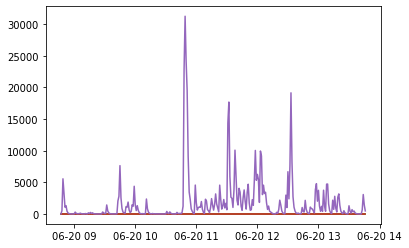



heikin_ashi
                         open      high       low     close
2020-06-20 08:47:00  0.000025  0.000025  0.000025  0.000025
2020-06-20 08:48:00  0.000025  0.000025  0.000025  0.000025
2020-06-20 08:49:00  0.000025  0.000025  0.000025  0.000025
2020-06-20 08:50:00  0.000025  0.000025  0.000025  0.000025
2020-06-20 08:51:00  0.000025  0.000025  0.000025  0.000025
...                       ...       ...       ...       ...
2020-06-20 13:42:00  0.000025  0.000025  0.000025  0.000025
2020-06-20 13:43:00  0.000025  0.000025  0.000025  0.000025
2020-06-20 13:44:00  0.000025  0.000025  0.000025  0.000025
2020-06-20 13:45:00  0.000025  0.000025  0.000025  0.000025
2020-06-20 13:46:00  0.000025  0.000025  0.000025  0.000025

[300 rows x 4 columns]


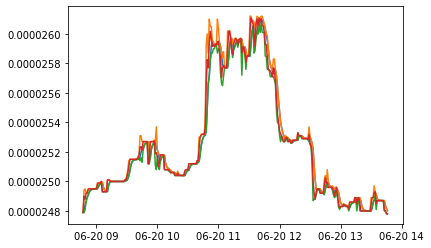



relative_volume_level
                       volume
time                         
2020-06-20 08:47:00       NaN
2020-06-20 08:48:00  0.000000
2020-06-20 08:49:00  0.000000
2020-06-20 08:50:00  0.000000
2020-06-20 08:51:00  0.000000
...                       ...
2020-06-20 13:42:00  0.000000
2020-06-20 13:43:00  0.264590
2020-06-20 13:44:00  0.522742
2020-06-20 13:45:00  0.086114
2020-06-20 13:46:00  0.000000

[300 rows x 1 columns]


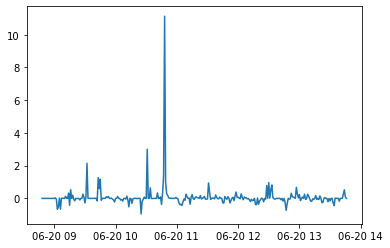



simple_moving_average
                         open      high       low     close  volume
time                                                               
2020-06-20 08:47:00  0.000025  0.000025  0.000025  0.000025   336.0
2020-06-20 08:48:00  0.000025  0.000025  0.000025  0.000025   336.0
2020-06-20 08:49:00  0.000025  0.000025  0.000025  0.000025  4235.0
2020-06-20 08:50:00  0.000025  0.000025  0.000025  0.000025  4950.5
2020-06-20 08:51:00  0.000025  0.000025  0.000025  0.000025  1051.5
...                       ...       ...       ...       ...     ...
2020-06-20 13:42:00  0.000025  0.000025  0.000025  0.000025     0.0
2020-06-20 13:43:00  0.000025  0.000025  0.000025  0.000025   471.5
2020-06-20 13:44:00  0.000025  0.000025  0.000025  0.000025  2614.5
2020-06-20 13:45:00  0.000025  0.000025  0.000025  0.000025  2438.5
2020-06-20 13:46:00  0.000025  0.000025  0.000025  0.000025   295.5

[300 rows x 5 columns]


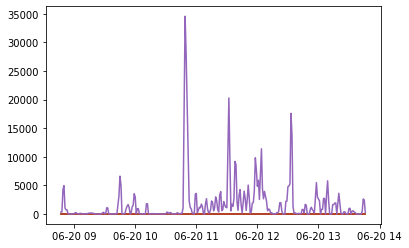



MACD_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    1.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Name: histogram, Length: 300, dtype: float64


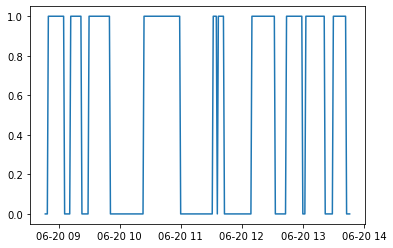



momentum_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    1.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    1.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


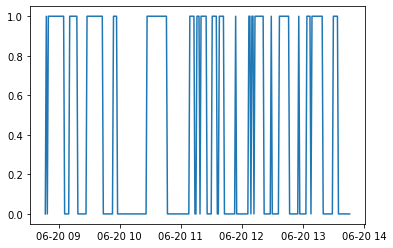



overtraded_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    1.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Name: close, Length: 300, dtype: float64


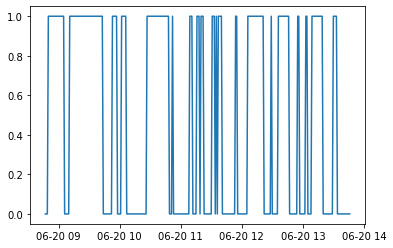



real_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    1.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


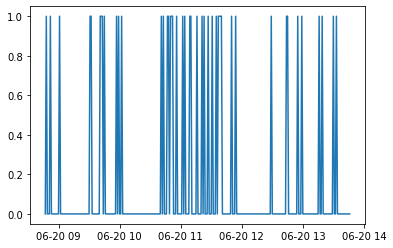



relative_volume_level_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Name: volume, Length: 300, dtype: float64


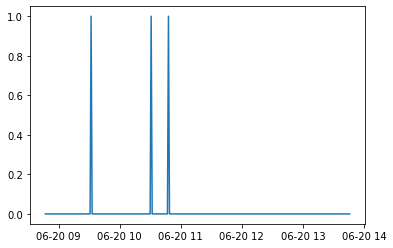



trend_strength_negative_trigger
time
2020-06-20 09:13:00    0.0
2020-06-20 09:14:00    0.0
2020-06-20 09:15:00    0.0
2020-06-20 09:16:00    0.0
2020-06-20 09:17:00    0.0
                      ... 
2020-06-20 13:41:00    1.0
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
Length: 273, dtype: float64


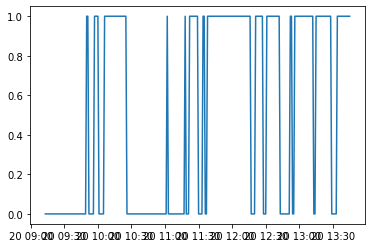



trend_strength_positive_trigger
time
2020-06-20 09:13:00    1.0
2020-06-20 09:14:00    1.0
2020-06-20 09:15:00    1.0
2020-06-20 09:16:00    1.0
2020-06-20 09:17:00    1.0
                      ... 
2020-06-20 13:41:00    0.0
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
Length: 273, dtype: float64


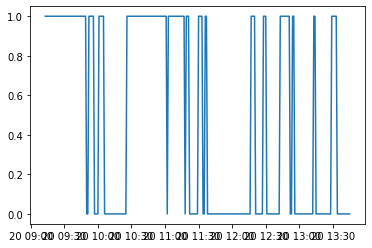



trend_strength_trigger
time
2020-06-20 09:13:00    1.0
2020-06-20 09:14:00    1.0
2020-06-20 09:15:00    1.0
2020-06-20 09:16:00    1.0
2020-06-20 09:17:00    1.0
                      ... 
2020-06-20 13:41:00    1.0
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
Name: ADX, Length: 273, dtype: float64


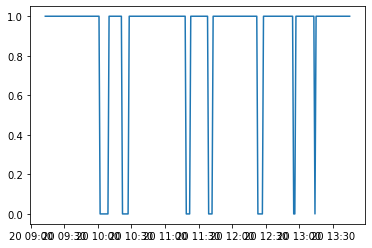



trend_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    1.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


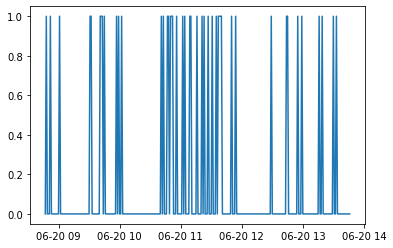



volatility_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


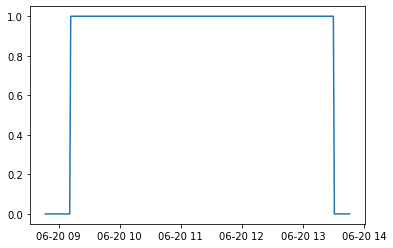





pair:  KNCBTC
interval:  1m
ATR
time
2020-06-20 08:47:00    3.218660e-07
2020-06-20 08:48:00    3.218660e-07
2020-06-20 08:49:00    3.218660e-07
2020-06-20 08:50:00    3.218660e-07
2020-06-20 08:51:00    3.218660e-07
                           ...     
2020-06-20 13:42:00    3.511565e-07
2020-06-20 13:43:00    3.467882e-07
2020-06-20 13:44:00    3.413033e-07
2020-06-20 13:45:00    3.583531e-07
2020-06-20 13:46:00    3.627564e-07
Length: 300, dtype: float64


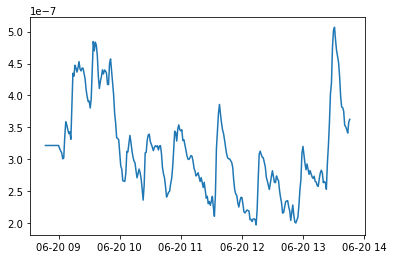



KDJ
                             K          D          J
time                                                
2020-06-20 08:47:00  66.666667  55.555556  88.888889
2020-06-20 08:48:00  71.825397  60.978836  93.518519
2020-06-20 08:49:00  59.788360  60.582011  58.201058
2020-06-20 08:50:00  67.239859  62.801293  76.116990
2020-06-20 08:51:00  70.316769  65.306452  80.337402
...                        ...        ...        ...
2020-06-20 13:42:00  58.250791  61.931841  50.888691
2020-06-20 13:43:00  69.728170  64.530617  80.123274
2020-06-20 13:44:00  59.410617  62.823950  52.583949
2020-06-20 13:45:00  39.607078  55.084993   8.651247
2020-06-20 13:46:00  41.710841  50.626942  23.878638

[300 rows x 3 columns]


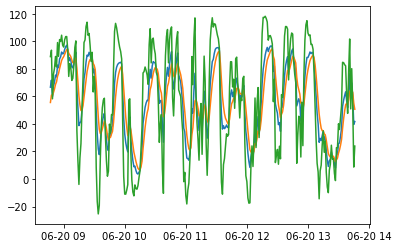



MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-20 08:47:00 -1.121795e-09 -1.121795e-09  0.000000e+00
2020-06-20 08:48:00 -1.121795e-09 -1.121795e-09  0.000000e+00
2020-06-20 08:49:00 -5.460682e-09 -2.900027e-09 -2.560654e-09
2020-06-20 08:50:00 -2.606664e-09 -2.800649e-09  1.939851e-10
2020-06-20 08:51:00 -2.194726e-09 -2.620401e-09  4.256748e-10
...                           ...           ...           ...
2020-06-20 13:42:00 -3.073587e-07 -3.792303e-07  7.187157e-08
2020-06-20 13:43:00 -2.732568e-07 -3.580356e-07  8.477878e-08
2020-06-20 13:44:00 -2.649632e-07 -3.394211e-07  7.445789e-08
2020-06-20 13:45:00 -3.017137e-07 -3.318796e-07  3.016595e-08
2020-06-20 13:46:00 -2.991482e-07 -3.253333e-07  2.618513e-08

[300 rows x 3 columns]


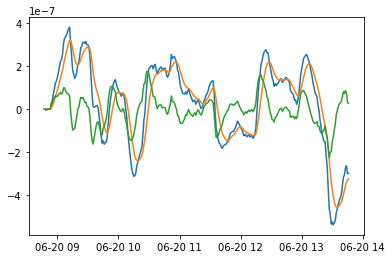



RSI
time
2020-06-20 08:47:00     0.000000
2020-06-20 08:48:00     0.000000
2020-06-20 08:49:00     0.000000
2020-06-20 08:50:00    46.418115
2020-06-20 08:51:00    41.316405
                         ...    
2020-06-20 13:42:00    43.201990
2020-06-20 13:43:00    53.401446
2020-06-20 13:44:00    44.781064
2020-06-20 13:45:00    31.965690
2020-06-20 13:46:00    43.310215
Name: close, Length: 300, dtype: float64


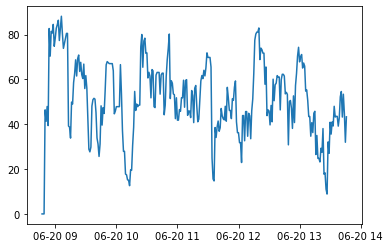



average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-20 09:13:00  0.670142  0.192744  0.404223
2020-06-20 09:14:00  0.626311  0.146672  0.326340
2020-06-20 09:15:00  0.534925  0.279326  0.285167
2020-06-20 09:16:00  0.458249  0.232316  0.237174
2020-06-20 09:17:00  0.419327  0.303290  0.207066
...                       ...       ...       ...
2020-06-20 13:41:00  0.238765  0.105494  0.161693
2020-06-20 13:42:00  0.227457  0.103443  0.141091
2020-06-20 13:43:00  0.268009  0.090780  0.296835
2020-06-20 13:44:00  0.322428  0.079940  0.413749
2020-06-20 13:45:00  0.373204  0.065985  0.378729

[273 rows x 3 columns]


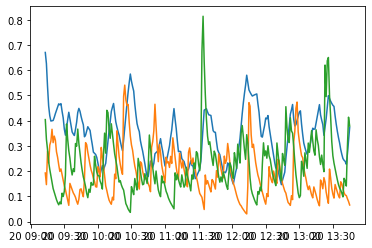



bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-20 09:06:00  0.000135  0.000135  0.000000e+00
2020-06-20 09:07:00  0.000135  0.000135  4.852268e-08
2020-06-20 09:08:00  0.000136  0.000135  1.048009e-07
2020-06-20 09:09:00  0.000136  0.000136  1.750760e-07
2020-06-20 09:10:00  0.000136  0.000136  2.545569e-07
...                       ...       ...           ...
2020-06-20 13:42:00  0.000137  0.000136  1.096909e-06
2020-06-20 13:43:00  0.000137  0.000135  1.060819e-06
2020-06-20 13:44:00  0.000136  0.000135  1.015538e-06
2020-06-20 13:45:00  0.000136  0.000135  9.653319e-07
2020-06-20 13:46:00  0.000136  0.000135  9.091153e-07

[281 rows x 3 columns]


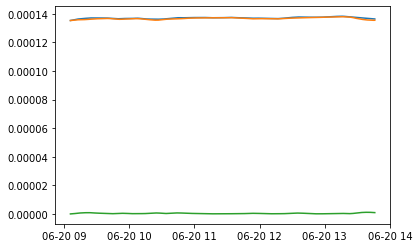



commodity_channel_index
time
2020-06-20 08:47:00         NaN
2020-06-20 08:48:00         NaN
2020-06-20 08:49:00         NaN
2020-06-20 08:50:00         NaN
2020-06-20 08:51:00         NaN
                         ...   
2020-06-20 13:42:00   -0.198501
2020-06-20 13:43:00    0.732826
2020-06-20 13:44:00   -0.565476
2020-06-20 13:45:00   -2.404035
2020-06-20 13:46:00   -1.780570
Name: CCI, Length: 300, dtype: float64


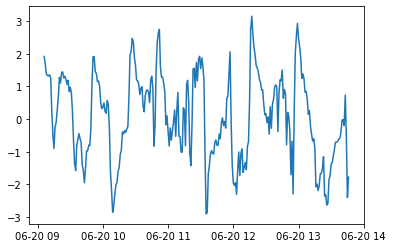



exponential_moving_average
                         open      high       low     close       volume
time                                                                    
2020-06-20 08:47:00  0.000134  0.000135  0.000134  0.000135  6045.000000
2020-06-20 08:48:00  0.000134  0.000135  0.000134  0.000135  1512.000000
2020-06-20 08:49:00  0.000134  0.000135  0.000134  0.000134   492.923077
2020-06-20 08:50:00  0.000134  0.000135  0.000134  0.000134   231.075000
2020-06-20 08:51:00  0.000134  0.000134  0.000134  0.000134  1022.280992
...                       ...       ...       ...       ...          ...
2020-06-20 13:42:00  0.000136  0.000136  0.000136  0.000136   893.397570
2020-06-20 13:43:00  0.000136  0.000136  0.000136  0.000136   473.799190
2020-06-20 13:44:00  0.000136  0.000136  0.000136  0.000136   446.599730
2020-06-20 13:45:00  0.000136  0.000136  0.000136  0.000136   708.866577
2020-06-20 13:46:00  0.000136  0.000136  0.000135  0.000136  2437.622192

[300 rows x 5 columns

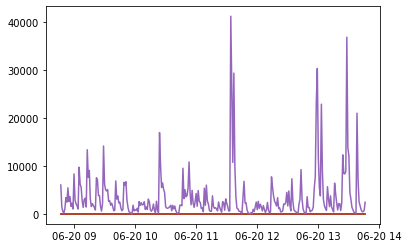



heikin_ashi
                         open      high       low     close
2020-06-20 08:47:00  0.000134  0.000135  0.000134  0.000134
2020-06-20 08:48:00  0.000134  0.000134  0.000134  0.000134
2020-06-20 08:49:00  0.000134  0.000135  0.000134  0.000134
2020-06-20 08:50:00  0.000134  0.000135  0.000134  0.000135
2020-06-20 08:51:00  0.000134  0.000134  0.000134  0.000134
...                       ...       ...       ...       ...
2020-06-20 13:42:00  0.000136  0.000136  0.000136  0.000136
2020-06-20 13:43:00  0.000136  0.000136  0.000136  0.000136
2020-06-20 13:44:00  0.000136  0.000136  0.000136  0.000136
2020-06-20 13:45:00  0.000136  0.000136  0.000135  0.000136
2020-06-20 13:46:00  0.000136  0.000136  0.000135  0.000136

[300 rows x 4 columns]


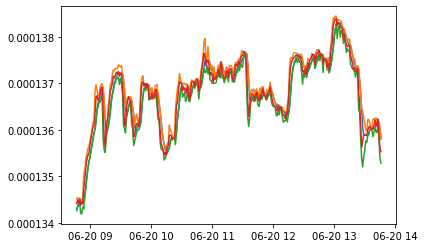



relative_volume_level
                       volume
time                         
2020-06-20 08:47:00       NaN
2020-06-20 08:48:00  0.000000
2020-06-20 08:49:00  0.000000
2020-06-20 08:50:00  0.000000
2020-06-20 08:51:00  0.000000
...                       ...
2020-06-20 13:42:00 -0.493158
2020-06-20 13:43:00 -0.039030
2020-06-20 13:44:00 -0.219308
2020-06-20 13:45:00  0.006966
2020-06-20 13:46:00  0.022463

[300 rows x 1 columns]


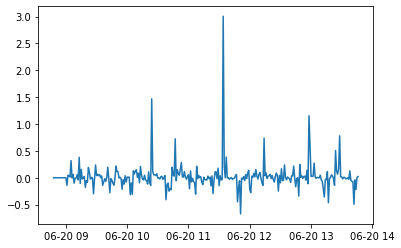



simple_moving_average
                         open      high       low     close  volume
time                                                               
2020-06-20 08:47:00  0.000134  0.000135  0.000134  0.000135  3023.0
2020-06-20 08:48:00  0.000134  0.000135  0.000134  0.000135  3023.0
2020-06-20 08:49:00  0.000134  0.000135  0.000134  0.000134    20.5
2020-06-20 08:50:00  0.000134  0.000135  0.000134  0.000134    72.5
2020-06-20 08:51:00  0.000134  0.000135  0.000134  0.000134   759.0
...                       ...       ...       ...       ...     ...
2020-06-20 13:42:00  0.000136  0.000136  0.000136  0.000136   879.0
2020-06-20 13:43:00  0.000136  0.000136  0.000136  0.000136   380.5
2020-06-20 13:44:00  0.000136  0.000136  0.000136  0.000136   348.5
2020-06-20 13:45:00  0.000136  0.000136  0.000136  0.000136   636.5
2020-06-20 13:46:00  0.000136  0.000136  0.000135  0.000136  2071.0

[300 rows x 5 columns]


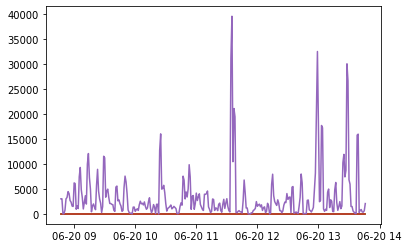



MACD_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    1.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
2020-06-20 13:46:00    1.0
Name: histogram, Length: 300, dtype: float64


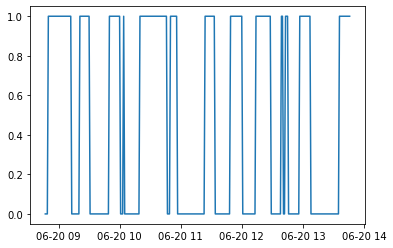



momentum_trigger
time
2020-06-20 08:47:00    1.0
2020-06-20 08:48:00    1.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    1.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Length: 300, dtype: float64


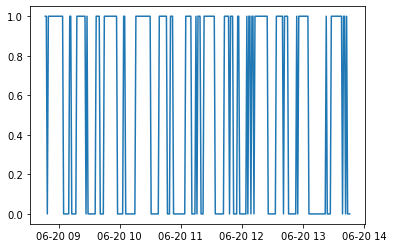



overtraded_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    1.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    1.0
Name: close, Length: 300, dtype: float64


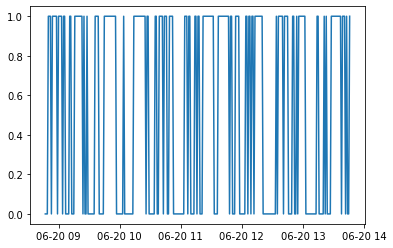



real_trigger
time
2020-06-20 08:47:00    1.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    1.0
Length: 300, dtype: float64


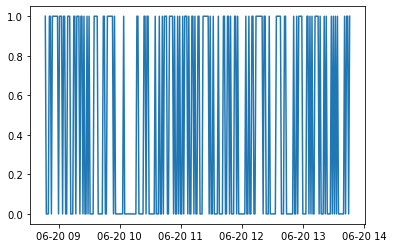



relative_volume_level_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    0.0
Name: volume, Length: 300, dtype: float64


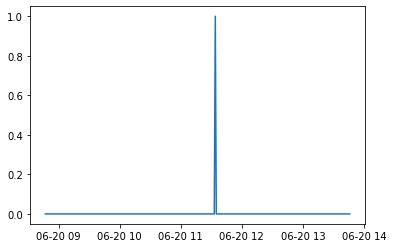



trend_strength_negative_trigger
time
2020-06-20 09:13:00    1.0
2020-06-20 09:14:00    1.0
2020-06-20 09:15:00    1.0
2020-06-20 09:16:00    1.0
2020-06-20 09:17:00    0.0
                      ... 
2020-06-20 13:41:00    1.0
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
Length: 273, dtype: float64


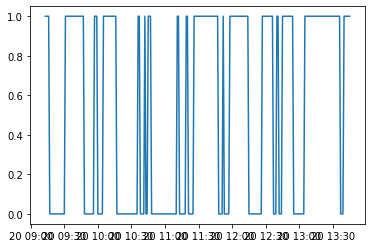



trend_strength_positive_trigger
time
2020-06-20 09:13:00    0.0
2020-06-20 09:14:00    0.0
2020-06-20 09:15:00    0.0
2020-06-20 09:16:00    0.0
2020-06-20 09:17:00    1.0
                      ... 
2020-06-20 13:41:00    0.0
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    0.0
2020-06-20 13:44:00    0.0
2020-06-20 13:45:00    0.0
Length: 273, dtype: float64


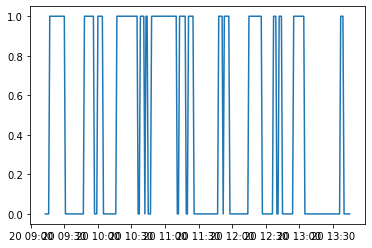



trend_strength_trigger
time
2020-06-20 09:13:00    1.0
2020-06-20 09:14:00    1.0
2020-06-20 09:15:00    1.0
2020-06-20 09:16:00    1.0
2020-06-20 09:17:00    1.0
                      ... 
2020-06-20 13:41:00    0.0
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
Name: ADX, Length: 273, dtype: float64


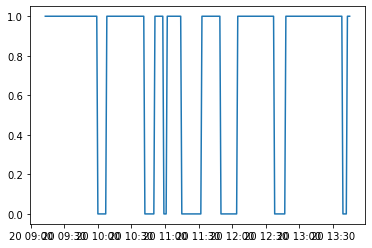



trend_trigger
time
2020-06-20 08:47:00    1.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    1.0
                      ... 
2020-06-20 13:42:00    0.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    0.0
2020-06-20 13:46:00    1.0
Length: 300, dtype: float64


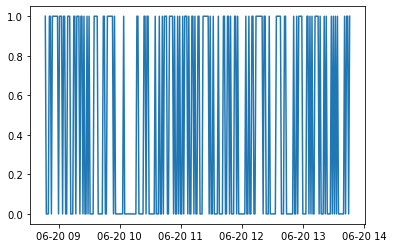



volatility_trigger
time
2020-06-20 08:47:00    0.0
2020-06-20 08:48:00    0.0
2020-06-20 08:49:00    0.0
2020-06-20 08:50:00    0.0
2020-06-20 08:51:00    0.0
                      ... 
2020-06-20 13:42:00    1.0
2020-06-20 13:43:00    1.0
2020-06-20 13:44:00    1.0
2020-06-20 13:45:00    1.0
2020-06-20 13:46:00    1.0
Length: 300, dtype: float64


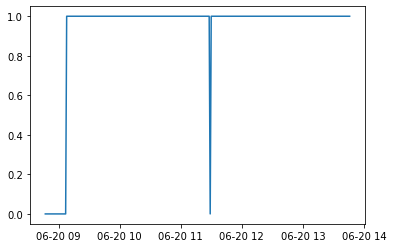

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot)

In [ ]:
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000
    percentage_to_trade = 0.9999

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    pair = crypto_bot.pairs[symbol]
    pair_at_interval = pair.interval[interval]
    dataset = pair_at_interval.dataset
    precision = pair.info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-100:]
        else:
            dataset = dataset.append(last_data).iloc[-100:]

        pair_at_interval.dataset = dataset
        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.traded_pair_symbol:
            volatility_trigger = pair_at_interval.indicators.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)


bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()


while True:
    time.sleep(20)

    crypto_bot.assets = dict.fromkeys(crypto_bot.assets.keys(), 0)

    for pair in crypto_bot.pairs.keys():
        crypto_bot.pairs[pair].info.calculate_balance()
        crypto_bot.pairs[pair].calculate_position()

    for asset in crypto_bot.assets.keys():
        for pair in crypto_bot.pairs.keys():
            if crypto_bot.pairs[pair].info.base_asset == asset:
                if crypto_bot.pairs[pair].interval['1m'].indicators.indicators.real_trigger.value.iloc[-1] and \
                        crypto_bot.pairs[pair].interval['1m'].indicators.indicators.relative_volume_level_trigger.value.iloc[-1]:

                    crypto_bot.assets[asset] += 1
                else:
                    crypto_bot.assets[asset] -= 1

            elif crypto_bot.pairs[pair].info.quote_asset == asset:
                if crypto_bot.pairs[pair].interval['1m'].indicators.indicators.real_trigger.value.iloc[-1] and \
                        crypto_bot.pairs[pair].interval['1m'].indicators.indicators.relative_volume_level_trigger.value.iloc[-1]:

                    crypto_bot.assets[asset] -= 1
                else:
                    crypto_bot.assets[asset] += 1

    best_assets = [asset for asset in crypto_bot.assets.keys() if crypto_bot.assets[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.base_asset in best_assets or \
            crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.quote_asset in best_assets):

        if crypto_bot.pairs[crypto_bot.traded_pair_symbol].position == 'buy':
            asset = crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.base_asset
        elif crypto_bot.pairs[crypto_bot.traded_pair_symbol].position == 'sell':
            asset = crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.quote_asset

        target_symbols = [pair for pair in crypto_bot.pairs.keys() \
                          if asset in pair and any([asset in pair for asset in best_assets])]

        target_symbol = target_symbols[0]
        crypto_bot.pairs[target_symbol].state = 'exit'

        if crypto_bot.pairs[target_symbol].info.base_asset == asset:
            crypto_bot.pairs[target_symbol].position = 'buy'
            crypto_bot.traded_asset_symbol = crypto_bot.pairs[target_symbol].info.base_asset
        elif crypto_bot.pairs[target_symbol].info.quote_asset == asset:
            crypto_bot.pairs[target_symbol].position = 'sell'
            crypto_bot.traded_asset_symbol = crypto_bot.pairs[target_symbol].info.quote_asset

        crypto_bot.traded_pair_symbol = target_symbol


'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''



pair:  STORJBTC
base_asset_balance:  0.6625
quote_asset_balance:  0.00773035
pair_last_price:  0.00002046
pair_buy_balance:  377.82746823
pair_sell_balance:  0.00001355
pair_combined_base_balance:  378.48996823
pair_combined_quote_balance:  0.0077439




pair:  KNCBTC
base_asset_balance:  0.9514
quote_asset_balance:  0.00773035
pair_last_price:  0.00013565
pair_buy_balance:  56.98746775
pair_sell_balance:  0.00012906
pair_combined_base_balance:  57.93886775
pair_combined_quote_balance:  0.00785941


best_assets:  ['BTC']


pair:  STORJBTC
base_asset_balance:  0.6625
quote_asset_balance:  0.00773035
pair_last_price:  0.00002046
pair_buy_balance:  377.82746823
pair_sell_balance:  0.00001355
pair_combined_base_balance:  378.48996823
pair_combined_quote_balance:  0.0077439




pair:  RDNBTC
base_asset_balance:  0.7588
quote_asset_balance:  0.00773035
pair_last_price:  0.00002486
pair_buy_balance:  310.95534996
pair_sell_balance:  0.00001886
pair_combined_base_balance:  311.71414996
pair_

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()